In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ast, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_yaml
tf.__version__

Using TensorFlow backend.


'2.2.0'

In [4]:
if os.getcwd()[0] == 'C':
    df = pd.read_csv('../Data/Flujo1.csv', sep=";")
else:
    from google.colab import drive
    drive.mount('/content/drive/')
    drive_route = 'drive/My Drive/Tesis/Data/'
    df = pd.read_csv(drive_route+'/Flujo1.csv', sep=";")
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)

def enumerate_dimensions(dimension, list_dimensions): 
    return list_dimensions.index(dimension)
def wordsToNumbers(tokens, vocabulary):
    number_array = []
    for i in tokens:
        number_array.append(vocabulary.index(i)+1)
    return np.asarray(number_array)

In [5]:
# Se Construye Dataframe solo de medio ambiente
df = df[df.Area == 'Social Interno']
# Lista de dimensiones se pasa a numeros
list_dimensions = df.Dimension.unique().tolist()
num_classes = len(list_dimensions)
df['_dimension'] = df['Dimension'].apply(enumerate_dimensions, list_dimensions = list_dimensions)

#Generamos un vocabulario de palabras
vocabulary = []
df['Respuesta'].apply(vocabulary.append)
vocabulary = [item for sublist in vocabulary for item in sublist]
vocabulary.append('')
vocabulary = list(sorted(set(vocabulary)))
vocab_len= len(vocabulary)+1

df['NumRespuesta'] = df.Respuesta.apply (wordsToNumbers, vocabulary = vocabulary)

# Rellenamos las matrices con 0 para que todas tengan el mismo tamaño
X_completo = pad_sequences(df.NumRespuesta, maxlen=10, dtype='object', padding='post', value = 0)
y_completo = np.array(df['_dimension'])

print('Media', np.array(df.groupby('_dimension').count().NumRespuesta).mean())
print('STD', np.std(df.groupby('_dimension').count().NumRespuesta))
print('Cant. datos', np.sum(df.groupby('_dimension').count().NumRespuesta))
print('Cant. datos', np.min(df.groupby('_dimension').count().NumRespuesta))
print('Cant. datos min ', np.min(df.groupby('_dimension').count().NumRespuesta))
print('Cant. datos max ', np.max(df.groupby('_dimension').count().NumRespuesta))

df.groupby('_dimension').count()

Media 5708.666666666667
STD 2110.6862496459403
Cant. datos 51378
Cant. datos 2579
Cant. datos min  2579
Cant. datos max  10057


,Area,Dimension,Respuesta,NumRespuesta
_dimension,,,,
0,5676,5676,5676,5676
1,6735,6735,6735,6735
2,2579,2579,2579,2579
3,6330,6330,6330,6330
4,2580,2580,2580,2580
5,10057,10057,10057,10057
6,6084,6084,6084,6084
7,5571,5571,5571,5571
8,5766,5766,5766,5766


# Busqueda de Hyperparametros

In [ ]:
def gen_train_model(tensor_X, tensor_y, tensor_test_x, tensor_test_y, paramsEmbedding, paramsLSTM, num_clases, optimizer, batch_size, epoch):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim = paramsEmbedding['input_dim'],  output_dim = paramsEmbedding['output_dim'], input_shape=(tensor_X.shape[1],)))
    model.add(tf.keras.layers.LSTM(units = paramsLSTM['units'],
                                   activation = paramsLSTM['activation'],
                                   dropout = paramsLSTM['dropout'],
                                   recurrent_dropout = paramsLSTM['recurrent_dropout']))
    
    model.add(tf.keras.layers.Dense(units = num_clases ,activation='softmax'))
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    history = model.fit(tensor_X,
                        tensor_y,
                        epochs = epoch,
                        batch_size = batch_size,
                        verbose = 0
                       )
    test_loss, test_acurracy = model.evaluate(tensor_test_x,
                                              tensor_test_y,
                                              verbose=0
                                             )
    
    predictions = model.predict_classes(tensor_test_x)
    medidas = precision_recall_fscore_support(tensor_test_y, predictions )
    print(medidas[0])
    return [test_acurracy, test_loss, medidas, paramsEmbedding, paramsLSTM, optimizer, batch_size, epoch]


def grid_lstm(data_x, data_y, input_dim, output_dim_embe, units_lstm, activ_lstm, drop_lstm, rec_drop_lstm, num_clases, optimizers, batch_size_, epochs):
    X, test_x, y, test_y = train_test_split(data_x, data_y, test_size = 0.1, random_state = 0)
    tensor_X      = tf.convert_to_tensor(list(X))
    tensor_test_x = tf.convert_to_tensor(list(test_x))
    tensor_y      = tf.convert_to_tensor(list(y))
    tensor_test_y = tf.convert_to_tensor(list(test_y))
    resultados = []
    for output_dim in output_dim_embe:
        for units in units_lstm:
            for activ in activ_lstm:
                for drop in drop_lstm:
                    for rec_drop in rec_drop_lstm:
                        for optimizer in optimizers:
                            for batch_size in batch_size_:
                                for epoch in epochs:
                                    resultados.append( gen_train_model(tensor_X, tensor_y, tensor_test_x, tensor_test_y,  {'input_dim': input_dim, 'output_dim':output_dim}, 
                                                    {'units':units,'activation':activ,'dropout':drop, 'recurrent_dropout':rec_drop},
                                                   num_clases, optimizer, batch_size, epoch))
    return resultados

output = grid_lstm(data_x = X_completo,
          data_y = y_completo,
          input_dim = len(vocabulary)+1,
          num_clases = len(list_dimensions),
          output_dim_embe = [60, 90],
          units_lstm = [60, 90],
          activ_lstm = ['tanh', 'relu'],
          drop_lstm = [0.3,0.5,0.7],
          rec_drop_lstm = [0.3,0.5,0.7],
          optimizers = ['rmsprop','adam'],
          batch_size_ = [20, 40],
          epochs = [6,8]
         )


In [6]:
epoch = 6
batch_size = 40
optimizer = 'rmsprop'
recurrent_dropout = 0.7
dropout = 0.3
activation_lstm = 'relu'
lstm_units = 90
ouput_dim_embedding = 90

kf = KFold(n_splits = 10, shuffle = True, random_state = 2)
resultados = []
contador = 1
for valores_entrenamiento, valores_testeo in kf.split(X_completo):
    
    tensor_X      = tf.convert_to_tensor(list(X_completo[valores_entrenamiento]))
    tensor_test_x = tf.convert_to_tensor(list(X_completo[valores_testeo]))
    tensor_y      = tf.convert_to_tensor(list(y_completo[valores_entrenamiento]))
    tensor_test_y = tf.convert_to_tensor(list(y_completo[valores_testeo]))
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim = vocab_len, 
                                        output_dim = ouput_dim_embedding,
                                        input_shape=(X_completo.shape[1],)))
    
    model.add(tf.keras.layers.LSTM(units=lstm_units,
                                   activation=activation_lstm,
                                   dropout = dropout,
                                   recurrent_dropout = recurrent_dropout))
    
    model.add(tf.keras.layers.Dense(units=num_classes,
                                    activation='sigmoid'))
    
    model.compile(optimizer = optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    history = model.fit(tensor_X,
                        tensor_y,
                        epochs = epoch,
                        batch_size = batch_size,
                        verbose=0
                       )
    
    test_loss, test_acurracy = model.evaluate(tensor_test_x,
                                              tensor_test_y,
                                              verbose=0
                                             )
    predictions = model.predict_classes(tensor_test_x)
    medidas = precision_recall_fscore_support(tensor_test_y, predictions)
    resultados.append([test_loss, test_acurracy, medidas])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [7]:
print("loss mean",np.array([res[0] for res in resultados]).mean())
print("acurracy mean",np.array([res[1] for res in resultados]).mean())
print("media precision",np.array([np.array([res[2][0][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media recall",np.array([np.array([res[2][1][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media fscore",np.array([np.array([res[2][2][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media support",np.array([np.array([res[2][3][i] for res in resultados]).mean() for i in range(num_classes)]).mean())

loss mean 0.7762803554534912
acurracy mean 0.7656585216522217
media precision 0.7512954037693786
media recall 0.736257529660804
media fscore 0.7410080846740484
media support 570.8666666666667


In [8]:
model.save('complete_social_int.h5')
model_ = tf.keras.models.load_model('complete_social_int.h5')

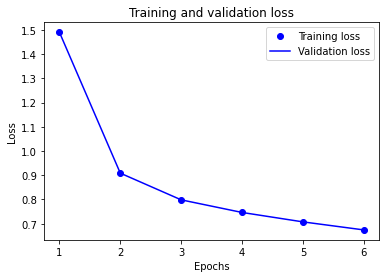

In [9]:
import matplotlib.pyplot as plt
history_dict = history.history
acc = history_dict['sparse_categorical_accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

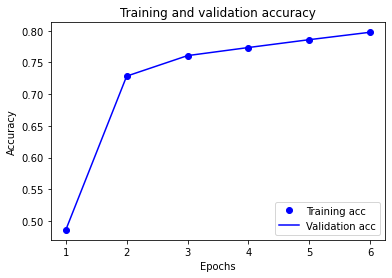

In [10]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [11]:
#Falta ROC Multiclase
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(tensor_test_y, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ValueError: multiclass format is not supported

# Antiguo

In [29]:
vocab_len= len(vocabulary)+1
num_classes = len(list_dimensions) #9
ouput_dim_embedding = 100
lstm_units = 200
ouputs_dense = num_classes
epoch = 7
batch_size = 100
optimizer = 'adam'

model = tf.keras.Sequential()
#Se agrega capa embedding que hace w2v
model.add(tf.keras.layers.Embedding(input_dim=vocab_len, output_dim = ouput_dim_embedding, input_shape=(X_completo.shape[1],)))
#model.add(tf.keras.layers.SpatialDropout1D(0.4))
model.add(tf.keras.layers.LSTM(units=lstm_units, activation='sigmoid', dropout=0.7, recurrent_dropout=0.7))
model.add(tf.keras.layers.Dense(units=ouputs_dense, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
history = model.fit(X, y, epochs = epoch, batch_size=batch_size)
print()
print('Resultados con datos de testeo ')
print()
test_loss, test_acurracy = model.evaluate(test_x, test_y)
print()
print('Data Test accuracy: {}'.format(test_acurracy))
predictions = model.predict_classes(test_x)
resultados.append(test_acurracy)
#Matriz de confusion
confusion = tf.confusion_matrix(labels=test_y, predictions= predictions, dtype=tf.dtypes.int32, num_classes=num_classes)
print('-Matriz de confusion')
print(confusion.eval(session=tf.Session()))
resultados


Train on 41073 samples
Epoch 1/7
41073/41073 [==============================] - 9s 211us/sample - loss: 2.0185 - sparse_categorical_accuracy: 0.2403
Epoch 2/7
41073/41073 [==============================] - 8s 194us/sample - loss: 1.1987 - sparse_categorical_accuracy: 0.6281
Epoch 3/7
41073/41073 [==============================] - 8s 191us/sample - loss: 0.8866 - sparse_categorical_accuracy: 0.7326
Epoch 4/7
41073/41073 [==============================] - 8s 191us/sample - loss: 0.7618 - sparse_categorical_accuracy: 0.7712
Epoch 5/7
41073/41073 [==============================] - 8s 194us/sample - loss: 0.6896 - sparse_categorical_accuracy: 0.7930
Epoch 6/7
41073/41073 [==============================] - 8s 194us/sample - loss: 0.6337 - sparse_categorical_accuracy: 0.8088
Epoch 7/7
41073/41073 [==============================] - 8s 191us/sample - loss: 0.5895 - sparse_categorical_accuracy: 0.8252

Resultados con datos de testeo 

10269/10269 [==============================] - 2s 203us/sampl

[0.75800955, 0.7533353, 0.7598598, 0.75839907, 0.7559646]

In [0]:
vocab_len= len(vocabulary)+1
num_classes = len(list_dimensions) #9
ouput_dim_embedding = 60
lstm_units = 100
ouputs_dense = num_classes
epoch = 7
batch_size = 60
optimizer = 'adam'

kf = KFold(n_splits = 10, shuffle = True, random_state = 2)
resultados = []
contador = 1
for valores_entrenamiento, valores_testeo in kf.split(X_completo):
    model = tf.keras.Sequential()
    #Se agrega capa embedding que hace w2v
    model.add(tf.keras.layers.Embedding(input_dim=vocab_len, output_dim = ouput_dim_embedding, input_shape=(X_completo.shape[1],)))
    model.add(tf.keras.layers.LSTM(units=lstm_units, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(units=ouputs_dense, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    history = model.fit(X_completo[valores_entrenamiento], y_completo[valores_entrenamiento], epochs = epoch, batch_size = batch_size)
    print()
    print(contador, '-Resultados con datos de testeo ')
    print()
    test_loss, test_acurracy = model.evaluate(X_completo[valores_testeo], y_completo[valores_testeo])
    print()
    print(contador, '-Data Test accuracy: {}'.format(test_acurracy))
    resultados.append(test_acurracy)
    print()
    predictions = model.predict_classes(X_completo[valores_testeo])
    #Matriz de confusion
    confusion = tf.confusion_matrix(labels=y_completo[valores_testeo], predictions= predictions, dtype=tf.dtypes.int32, num_classes=num_classes)
    print(contador, '-Matriz de confusion')
    print(confusion.eval(session=tf.Session()))
    print()
    contador = contador + 1

Train on 46207 samples
Epoch 1/7
46207/46207 [==============================] - 20s 427us/sample - loss: 1.7527 - sparse_categorical_accuracy: 0.3927
Epoch 2/7
46207/46207 [==============================] - 19s 415us/sample - loss: 1.0083 - sparse_categorical_accuracy: 0.6928
Epoch 3/7
46207/46207 [==============================] - 19s 412us/sample - loss: 0.8484 - sparse_categorical_accuracy: 0.7470
Epoch 4/7
46207/46207 [==============================] - 19s 406us/sample - loss: 0.7774 - sparse_categorical_accuracy: 0.7666
Epoch 5/7
46207/46207 [==============================] - 19s 402us/sample - loss: 0.7315 - sparse_categorical_accuracy: 0.7782
Epoch 6/7
46207/46207 [==============================] - 19s 409us/sample - loss: 0.6973 - sparse_categorical_accuracy: 0.7868
Epoch 7/7
46207/46207 [==============================] - 19s 403us/sample - loss: 0.6736 - sparse_categorical_accuracy: 0.7930

1 -Resultados con datos de testeo 

5135/5135 [==============================] - 1s 267